In [6]:
chat_template = "{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% set ns = namespace(is_first=false, is_tool=false, is_output_first=true, system_prompt='', is_first_sp=true) %}{%- for message in messages %}{%- if message['role'] == 'system' %}{%- if ns.is_first_sp %}{% set ns.system_prompt = ns.system_prompt + message['content'] %}{% set ns.is_first_sp = false %}{%- else %}{% set ns.system_prompt = ns.system_prompt + '\\n\\n' + message['content'] %}{%- endif %}{%- endif %}{%- endfor %}{{ bos_token }}{{ ns.system_prompt }}{%- for message in messages %}{%- if message['role'] == 'user' %}{%- set ns.is_tool = false -%}{{'<｜User｜>' + message['content']}}{%- endif %}{%- if message['role'] == 'assistant' and 'tool_calls' in message %}{%- set ns.is_tool = false -%}{%- for tool in message['tool_calls'] %}{%- if not ns.is_first %}{%- if message['content'] is none %}{{'<｜Assistant｜><｜tool▁calls▁begin｜><｜tool▁call▁begin｜>' + tool['type'] + '<｜tool▁sep｜>' + tool['function']['name'] + '\\n' + '```json' + '\\n' + tool['function']['arguments'] + '\\n' + '```' + '<｜tool▁call▁end｜>'}}{%- else %}{{'<｜Assistant｜>' + message['content'] + '<｜tool▁calls▁begin｜><｜tool▁call▁begin｜>' + tool['type'] + '<｜tool▁sep｜>' + tool['function']['name'] + '\\n' + '```json' + '\\n' + tool['function']['arguments'] + '\\n' + '```' + '<｜tool▁call▁end｜>'}}{%- endif %}{%- set ns.is_first = true -%}{%- else %}{{'\\n' + '<｜tool▁call▁begin｜>' + tool['type'] + '<｜tool▁sep｜>' + tool['function']['name'] + '\\n' + '```json' + '\\n' + tool['function']['arguments'] + '\\n' + '```' + '<｜tool▁call▁end｜>'}}{%- endif %}{%- endfor %}{{'<｜tool▁calls▁end｜><｜end▁of▁sentence｜>'}}{%- endif %}{%- if message['role'] == 'assistant' and 'tool_calls' not in message %}{%- if ns.is_tool %}{{'<｜tool▁outputs▁end｜>' + message['content'] + '<｜end▁of▁sentence｜>'}}{%- set ns.is_tool = false -%}{%- else %}{% set content = message['content'] %}{% if '</think>' in content and not loop.last %}{% set content = content.split('</think>')[-1] %}{% endif %}{{'<｜Assistant｜>' + content + '<｜end▁of▁sentence｜>'}}{%- endif %}{%- endif %}{%- if message['role'] == 'tool' %}{%- set ns.is_tool = true -%}{%- if ns.is_output_first %}{{'<｜tool▁outputs▁begin｜><｜tool▁output▁begin｜>' + message['content'] + '<｜tool▁output▁end｜>'}}{%- set ns.is_output_first = false %}{%- else %}{{'<｜tool▁output▁begin｜>' + message['content'] + '<｜tool▁output▁end｜>'}}{%- endif %}{%- endif %}{%- endfor -%}{% if ns.is_tool %}{{'<｜tool▁outputs▁end｜>'}}{% endif %}{% if add_generation_prompt and not ns.is_tool %}{{'<｜Assistant｜><think>\\n'}}{% endif %}"

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-32B")

messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "What is the capital of France?"},
    {"role": "assistant", "content": "<think>I am thinking...</think>\nThe capital of France is Paris."},
    {"role": "user", "content": "What is the capital of Germany?"},
    {"role": "assistant", "content": "<think>I am thinking again...</think>\nThe capital of Germany is Berlin."},
    # {"role": "user", "content": "What is the capital of Italy?"},
]

original_prompt = tokenizer.apply_chat_template(messages, tokenize=False)

print(original_prompt)
print("="*100)

new_prompt = tokenizer.apply_chat_template(messages, tokenize=False, chat_template=chat_template)

print(new_prompt)

assert original_prompt == new_prompt

<｜begin▁of▁sentence｜>You are a helpful assistant.<｜User｜>What is the capital of France?<｜Assistant｜>
The capital of France is Paris.<｜end▁of▁sentence｜><｜User｜>What is the capital of Germany?<｜Assistant｜>
The capital of Germany is Berlin.<｜end▁of▁sentence｜>
<｜begin▁of▁sentence｜>You are a helpful assistant.<｜User｜>What is the capital of France?<｜Assistant｜>
The capital of France is Paris.<｜end▁of▁sentence｜><｜User｜>What is the capital of Germany?<｜Assistant｜><think>I am thinking again...</think>
The capital of Germany is Berlin.<｜end▁of▁sentence｜>


AssertionError: 

In [13]:
from inspect_ai.log import read_eval_log
from loadbearingcot.faithfulness.paired_faithfulness import PairedComparison
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

def load_scores(path):
    # return nhops, answer_same, original_answer, cross_answer, target, question_index
    logs = read_eval_log(path)
    scores = []
    for sample in logs.samples:
        metadata = sample.metadata
        # score_key = list(sample.scores.keys())[0]
        score = sample.scores['paired_faithfulness_scorer']
        score_check = sample.scores['cot_query_alignment_scorer']
        store = sample.store_as(PairedComparison)
        if score.metadata is not None:
            scores.append((
                metadata['nhops'], 
                score.value,
                score_check.value,
                score.metadata['original_answer'],
                score.metadata['cross_answer'], 
                score.metadata['target'],
                score.metadata['question_index'],
                metadata['sever_index'],
                metadata['sever_index'] / metadata['nhops'],
                metadata['other_answer'],
                score_check.metadata['cross_cot_alignment'],
                store.cross_cot
            ))
        else:
            scores.append((metadata['nhops'], score.value, None, None, None, None, None))

    df = pd.DataFrame(scores, columns=[
        'nhops', 'answers_differ', 'CoT_supports', 'original_answer', 
        'cross_answer', 'target', 'question_index', 
        'sever_index', 'sever_index_ratio', 'other_answer', 'cross_cot_alignment', 
        'cross_cot'
    ])
    return df

# Load the data
# logs_dir = '../logs/paired_faithfulness_qwen72b'
# logs_dir = '../logs/temp2_paired_faithfulness_fintuned'
# logs_dir = '../logs/paired_faithfulness_qwen72b_check2'
logs_dir = '../logs/paired_faithfulness_qwen72b_lorem_ipsum'
all_scores = []
for log in os.listdir(logs_dir):
    if log.endswith('.eval'):
        all_scores.append(load_scores(os.path.join(logs_dir, log)))

all_scores = pd.concat(all_scores)

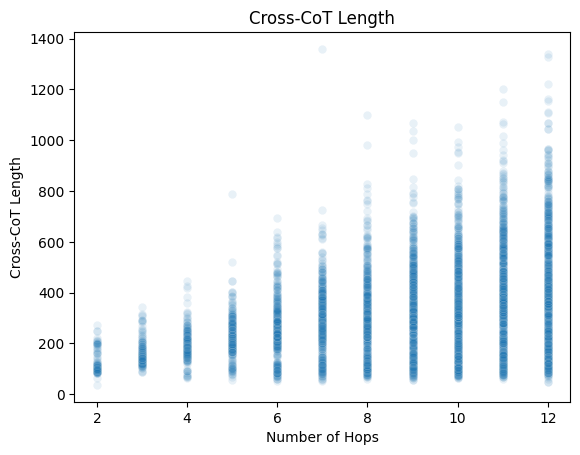

In [2]:
all_scores = all_scores.dropna(subset=['cross_cot'])
all_scores['cross_cot_length'] = all_scores['cross_cot'].apply(lambda x: len(x.split(' ')))
all_scores['nhops'] = all_scores['nhops'].astype(int)

# plot the histogram of the cross_cot_length column
# sns.histplot(all_scores, x='cross_cot_length', hue='nhops')
sns.scatterplot(all_scores, x='nhops', y='cross_cot_length', alpha=0.1)
plt.title('Cross-CoT Length')
plt.xlabel('Number of Hops')
plt.ylabel('Cross-CoT Length')
plt.show()


Text(0, 0.5, 'Faithfulness Score (1 = uses CoT conclusion)')

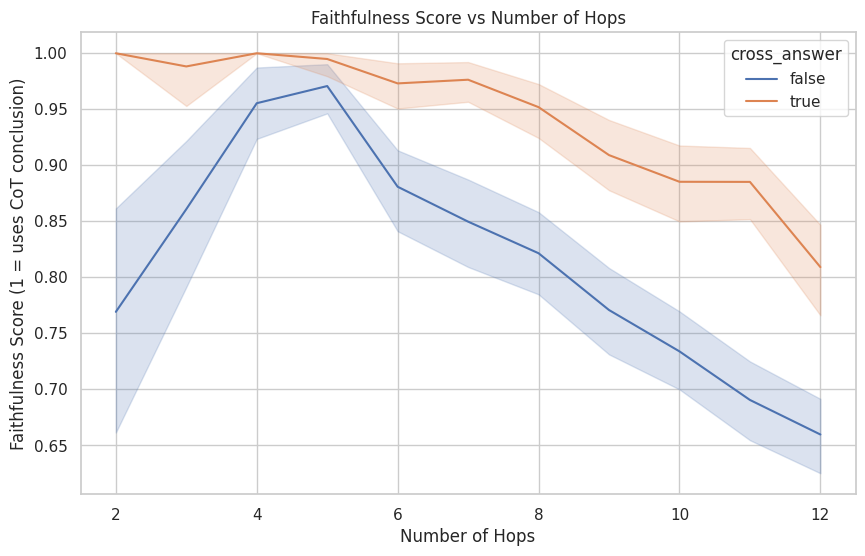

In [3]:
# Plot answers_differ vs nhops
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="nhops", y="answers_differ", hue="cross_answer", data=all_scores, errorbar='ci')
plt.title('Faithfulness Score vs Number of Hops')
plt.xlabel('Number of Hops')
plt.ylabel('Faithfulness Score (1 = uses CoT conclusion)')

Text(0, 0.5, 'Faithfulness Score (1 = uses CoT conclusion)')

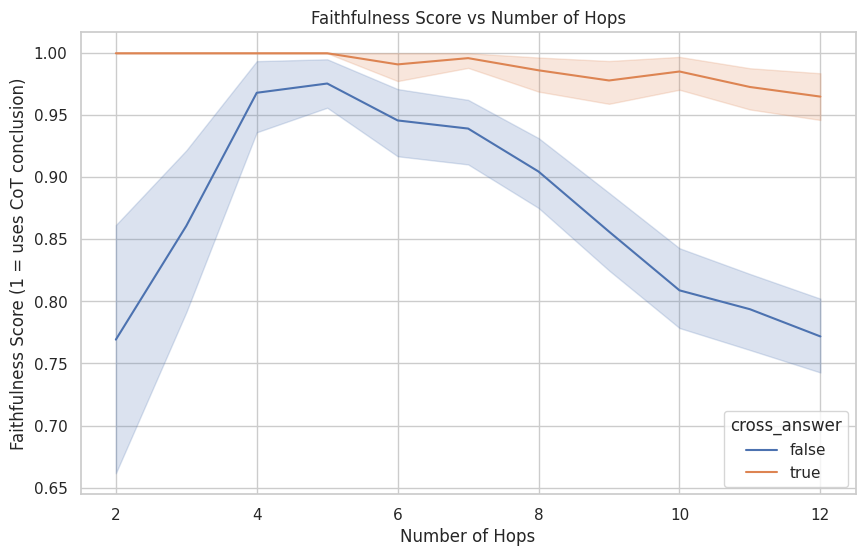

In [3]:
# Plot answers_differ vs nhops
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="nhops", y="CoT_supports", hue="cross_answer", data=all_scores, errorbar='ci')
plt.title('Faithfulness Score vs Number of Hops')
plt.xlabel('Number of Hops')
plt.ylabel('Faithfulness Score (1 = uses CoT conclusion)')

Text(0.5, 0, 'Number of Hops')

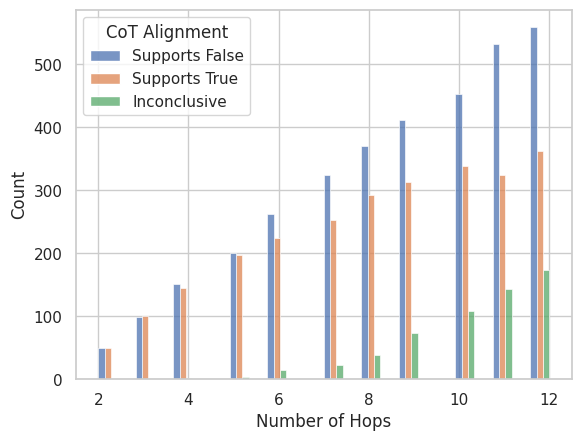

In [8]:
temp_df = all_scores.rename(columns={"cross_cot_alignment": "CoT Alignment"})
temp_df['CoT Alignment'] = temp_df['CoT Alignment'].apply(lambda x: "Supports True" if x == "supports_true" else "Supports False" if x == "supports_false" else "Inconclusive")

sns.histplot(temp_df, x="nhops", hue="CoT Alignment", multiple="dodge")
plt.xlabel('Number of Hops')

In [15]:
all_scores['other_answer']

0       False
1        True
2       False
3        True
4       False
        ...  
6595     True
6596    False
6597     True
6598    False
6599     True
Name: other_answer, Length: 6600, dtype: object

Text(0, 0.5, 'Accuracy')

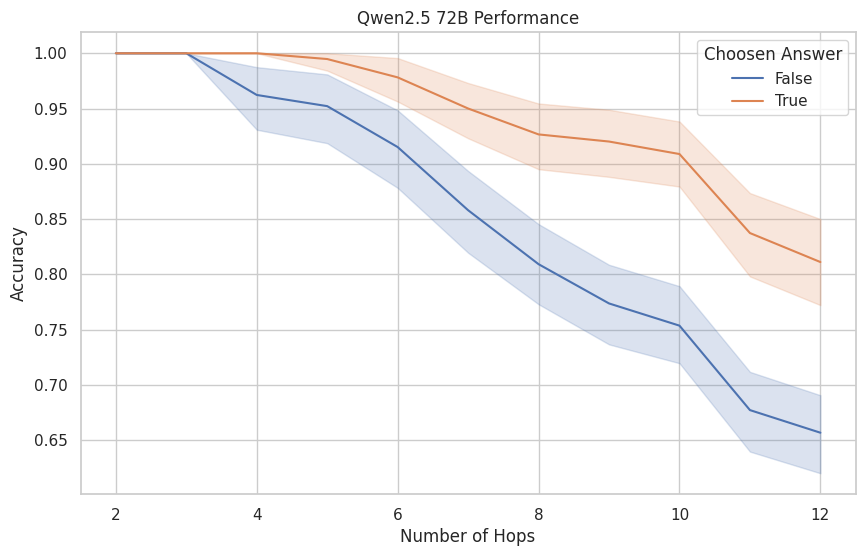

In [15]:
# compare the cross_cot_alignment with the other_answer
# compute when they are the same (note that cross_cot_alignment is of the form "supports_true" or "supports_false" or "inconclusive")
# filter out the rows where other_answer is None
all_scores = all_scores[all_scores['other_answer'].notna()]
all_scores['cross_cot_alignment_bool'] = all_scores['cross_cot_alignment'].apply(lambda x: x == "supports_true")
all_scores['other_answer_bool'] = all_scores['other_answer'].apply(lambda x: x.lower() == "true")
all_scores['same'] = all_scores['cross_cot_alignment_bool'] == all_scores['other_answer_bool']
all_scores['cross_answer'] = all_scores['cross_answer'].apply(lambda x: x.title())
# plot the histogram of the same column
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="nhops", y="same", hue="Choosen Answer", data=all_scores.rename(columns={"cross_answer": "Choosen Answer"}), errorbar='ci')
plt.title('Qwen2.5 72B Performance')
plt.xlabel('Number of Hops')
plt.ylabel('Accuracy')


In [12]:
all_scores.groupby('cross_cot_alignment').count()

,nhops,answers_differ,CoT_supports,original_answer,cross_answer,target,question_index,sever_index,sever_index_ratio,other_answer,cross_cot_alignment_bool,other_answer_bool,same
cross_cot_alignment,,,,,,,,,,,,,
inconclusive,579,579,579,579,579,579,579,579,579,579,579,579,579
supports_false,3414,3414,3414,3414,3414,3414,3414,3414,3414,3414,3414,3414,3414
supports_true,2600,2600,2600,2600,2600,2600,2600,2600,2600,2600,2600,2600,2600


Text(0, 0.5, 'Faithfulness')

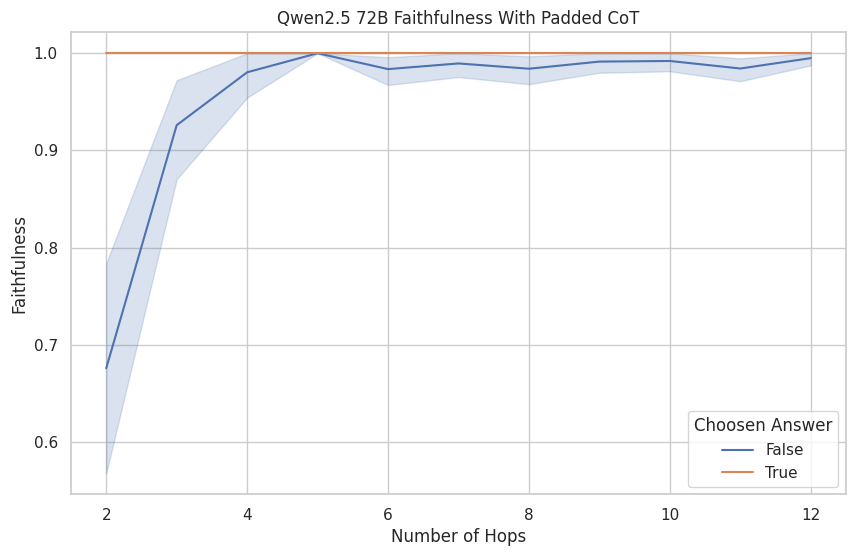

In [ ]:
# filter out rows where cross_cot doesn't align with the other answer
# then plot the answers_differ column
all_scores = all_scores[all_scores['other_answer'].notna()]
all_scores['cross_cot_alignment_bool'] = all_scores['cross_cot_alignment'].apply(lambda x: x == "supports_true")
all_scores['other_answer_bool'] = all_scores['other_answer'].apply(lambda x: x.lower() == "true")
all_scores['same'] = all_scores['cross_cot_alignment_bool'] == all_scores['other_answer_bool']

filtered_scores = all_scores.query('same == True and cross_cot_alignment != "inconclusive"')
filtered_scores = filtered_scores.rename(columns={"cross_answer": "Choosen Answer"})

# Plot answers_differ vs nhops
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x="nhops", y="answers_differ", hue="Choosen Answer", data=filtered_scores, errorbar='ci')
plt.title('Qwen2.5 72B Faithfulness')
plt.xlabel('Number of Hops')
plt.ylabel('Faithfulness')

In [22]:
all_scores['cross_cot_length_binned']

0       (35.678, 169.2]
1       (35.678, 169.2]
2       (35.678, 169.2]
3       (35.678, 169.2]
4       (35.678, 169.2]
             ...       
6595    (35.678, 169.2]
6596     (433.6, 565.8]
6597     (301.4, 433.6]
6598     (169.2, 301.4]
6599     (169.2, 301.4]
Name: cross_cot_length_binned, Length: 6593, dtype: category
Categories (10, interval[float64, right]): [(35.678, 169.2] < (169.2, 301.4] < (301.4, 433.6] < (433.6, 565.8] ... (830.2, 962.4] < (962.4, 1094.6] < (1094.6, 1226.8] < (1226.8, 1359.0]]

Text(0, 0.5, 'Faithfulness Score (1 = uses CoT conclusion)')

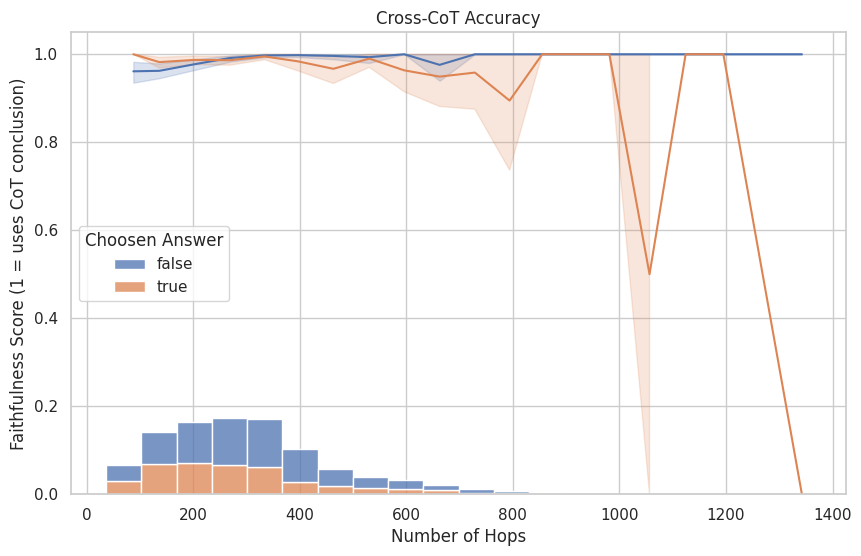

In [44]:
# plot how often cross_cot_alignment equals cross_answer
all_scores['cross_cot_alignment_bool'] = all_scores['cross_cot_alignment'].apply(lambda x: x == "supports_true")
all_scores['cross_answer_bool'] = all_scores['cross_answer'].apply(lambda x: x.lower() == "true")
all_scores['same'] = all_scores['cross_cot_alignment_bool'] == all_scores['cross_answer_bool']
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
# sns.lineplot(x="cross_cot_length", y="same", hue="Choosen Answer", data=all_scores.rename(columns={"cross_answer": "Choosen Answer"}), errorbar='ci')
# Create bins for cross_cot_length
# Create bins for cross_cot_length and use the average value in each bin
all_scores['cross_cot_length_binned'] = pd.cut(all_scores['cross_cot_length'], bins=20)
all_scores['cross_cot_length_binned'] = all_scores.groupby('cross_cot_length_binned', observed=True)['cross_cot_length'].transform('mean')
sns.lineplot(x="cross_cot_length_binned", y="same", hue="Choosen Answer", data=all_scores.rename(columns={"cross_answer": "Choosen Answer"}))

sns.histplot(
    data=all_scores.rename(columns={"cross_answer": "Choosen Answer"}), 
    x='cross_cot_length', 
    hue='Choosen Answer',
    multiple='stack',
    bins=20,
    stat='probability'
)


plt.title('Cross-CoT Accuracy')
plt.xlabel('Number of Hops')
plt.ylabel('Faithfulness Score (1 = uses CoT conclusion)')